In [43]:

import boto3
# print(f"SageMaker Version: {sagemaker.__version__}")
# print(f"Installation Path: {sagemaker.__file__}")
import sagemaker
from sagemaker.pytorch import PyTorch
from io import BytesIO
from botocore.exceptions import ClientError
from PIL import Image 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

import os
# Get the caller identity
sts_client = boto3.client('sts')

identity = sts_client.get_caller_identity()
arn = identity['Arn']
username = arn.split('/')[-1]
import botocore
from tqdm import tqdm
import os
import time
import sys
print(f"Account: {identity['Account']}")
print(f"UserId: {identity['UserId']}")
print(f"ARN: {identity['Arn']}")
print(f"Your AWS Username is: {username}")


Account: 253490779227
UserId: AIDATWBJ2KRN6C42QYYWF
ARN: arn:aws:iam::253490779227:user/amannindra2
Your AWS Username is: amannindra2


In [32]:
# REPLACE THIS STRING with the actual Role ARN you created in IAM
# role = "arn:aws:iam::253490779227:role/service-role/AmazonSageMakerAdminIAMExecutionRole" 
# boto_session = boto3.Session(region_name='us-west-1')
# sagemaker_session = sagemaker.Session(boto_session=boto_session)

# print(f"SageMaker Session Region: {sagemaker_session.boto_region_name}")
# print(f"Default Bucket: {sagemaker_session.default_bucket()}")

In [33]:
s3 = boto3.client("s3")

bucket_name = "animal-classification-dss-works"
train_folder = "data/train_features"
test_folder = "data/test_features"
train_features_csv = "data/train_features.csv"
test_features_csv = "data/test_features.csv"
train_labels_csv = "data/train_labels.csv"

response = s3.list_objects_v2(Bucket=bucket_name)



# for obj in response.get("Contents", []):
#     print(obj["Key"], obj["Size"])
train_labels = s3.get_object(
    Bucket=bucket_name, Key = train_labels_csv
)
# train_folder = s3.get_object(
#     Bucket=bucket_name, Key = "data/train"
# )   
# test_folder = s3.get_object(
#     Bucket=bucket_name, Key = "data/test"
# )


content = train_labels["Body"].read().decode("utf-8")
print(content)

id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ZJ000005,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ZJ000006,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
ZJ000007,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000008,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ZJ000009,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000010,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ZJ000011,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ZJ000012,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000013,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ZJ000014,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000015,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ZJ000016,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ZJ000017,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000018,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ZJ000019,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000020,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ZJ000021,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000022,1.0,0.0,0.0

In [ ]:
# s3://animal-classification-dss-works/data/train_features/ZJ000000.jpg

def get_image_keys_with_paginator(bucket, prefix):
    """Get all image keys using boto3 paginator"""
    image_keys = []
    
    # Create paginator
    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=bucket, Prefix=prefix)
    
    # Iterate through all pages
    for page in pages:
        for obj in page.get('Contents', []):
            key = obj['Key']
            if key.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                image_keys.append(key)
    
    return image_keys

def get_image_size(image_key: str) -> tuple[int, int]:
    
    image_key = os.path.join(train_folder, image_key)
    image_obj = s3.get_object(
        Bucket=bucket_name, Key = image_key
    )
    image_data = image_obj["Body"].read()
    image = Image.open(BytesIO(image_data))
    return image.size

def get_image_array(image_key: str) -> np.ndarray:
    # image_key = os.path.join(train_folder, image_key)
    image_obj = s3.get_object(
        Bucket=bucket_name, Key = image_key
    )
    image_data = image_obj["Body"].read()
    image = Image.open(BytesIO(image_data))
    return np.array(image)

# image_key = "ZJ000000.jpg"

# train_images = get_image_keys_with_paginator(bucket_name, 'data/test_features/')
# print(train_images)
# image_array = []

# for i in range(len(train_images)):
#     image_array.append(get_image_array(train_images[i]))
#     print(i)

# print(len(image_array))
# print(image_array)




['data/test_features/ZJ016488.jpg', 'data/test_features/ZJ016489.jpg', 'data/test_features/ZJ016490.jpg', 'data/test_features/ZJ016491.jpg', 'data/test_features/ZJ016492.jpg', 'data/test_features/ZJ016493.jpg', 'data/test_features/ZJ016494.jpg', 'data/test_features/ZJ016495.jpg', 'data/test_features/ZJ016496.jpg', 'data/test_features/ZJ016497.jpg', 'data/test_features/ZJ016498.jpg', 'data/test_features/ZJ016499.jpg', 'data/test_features/ZJ016500.jpg', 'data/test_features/ZJ016501.jpg', 'data/test_features/ZJ016502.jpg', 'data/test_features/ZJ016503.jpg', 'data/test_features/ZJ016504.jpg', 'data/test_features/ZJ016505.jpg', 'data/test_features/ZJ016506.jpg', 'data/test_features/ZJ016507.jpg', 'data/test_features/ZJ016508.jpg', 'data/test_features/ZJ016509.jpg', 'data/test_features/ZJ016510.jpg', 'data/test_features/ZJ016511.jpg', 'data/test_features/ZJ016512.jpg', 'data/test_features/ZJ016513.jpg', 'data/test_features/ZJ016514.jpg', 'data/test_features/ZJ016515.jpg', 'data/test_features

In [ ]:
sizes = []

def get_image_size(image_key: str) -> tuple[int, int]:
    
    image_obj = s3.get_object(
        Bucket=bucket_name, Key = image_key
    )
    image_data = image_obj["Body"].read()
    image = Image.open(BytesIO(image_data))
    return image.size

    
def get_image_keys_with_paginator(bucket, prefix):
    """Get all image keys using boto3 paginator"""
    image_keys = []
    
    # Create paginator
    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=bucket, Prefix=prefix)
    
    # Iterate through all pages
    for page in pages:
        for obj in page.get('Contents', []):
            key = obj['Key']
            if key.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                image_keys.append(key)
    
    return image_keys





16488


In [ ]:

# test_images = get_image_keys_with_paginator(bucket_name, 'data/train_features/')
# print(len(test_images))

# limit = 0
# t = time.time()
# for i in test_images:
#     if limit % 10 == 0:
#         print(time.time() - t)
#         print(limit)
#     limit += 1
#     sizes.append(get_image_size(i))
#     if limit == 100:
#         break

5.888938903808594e-05
0
5.599632978439331
10
8.648099899291992
20
11.6250319480896
30
17.67985486984253
40
20.89880609512329
50
23.845614910125732
60
27.189374923706055
70
30.141650915145874
80
33.07092571258545
90


In [29]:
sizes

[(960, 540),
 (960, 540),
 (640, 360),
 (640, 360),
 (640, 335),
 (960, 540),
 (960, 540),
 (640, 360),
 (960, 540),
 (960, 515),
 (640, 335),
 (640, 360),
 (160, 120),
 (960, 540),
 (640, 360),
 (640, 360),
 (360, 215),
 (160, 120),
 (360, 240),
 (640, 360),
 (360, 215),
 (960, 540),
 (640, 360),
 (960, 515),
 (640, 360),
 (960, 540),
 (640, 360),
 (960, 540),
 (360, 240),
 (960, 540),
 (640, 360),
 (960, 540),
 (640, 360),
 (960, 540),
 (960, 540),
 (960, 540),
 (960, 540),
 (640, 360),
 (960, 540),
 (960, 540),
 (960, 540),
 (360, 240),
 (360, 240),
 (960, 540),
 (960, 540),
 (640, 360),
 (640, 360),
 (640, 360),
 (640, 360),
 (960, 540),
 (960, 540),
 (640, 360),
 (360, 240),
 (960, 515),
 (960, 540),
 (640, 360),
 (960, 540),
 (960, 540),
 (640, 360),
 (640, 360),
 (640, 360),
 (640, 360),
 (960, 540),
 (640, 335),
 (640, 360),
 (960, 540),
 (960, 540),
 (960, 540),
 (960, 540),
 (960, 540),
 (640, 360),
 (960, 540),
 (640, 360),
 (960, 540),
 (640, 360),
 (960, 540),
 (960, 540),

In [30]:
unique_sizes = list(set(sizes))
unique_sizes



[(160, 120),
 (960, 515),
 (640, 335),
 (960, 540),
 (640, 360),
 (360, 215),
 (360, 240)]

In [35]:

def get_image_from_s3(bucket, key):
    """Get image from S3 without downloading to disk"""
    try:
        response = s3.get_object(Bucket=bucket, Key=key)
        image = Image.open(BytesIO(response["Body"].read()))
        return image
    except Exception as e:
        print(f"Error loading")
        return None


def get_all_image_keys(bucket, prefix):
    """Get all image keys from S3 folder"""
    print(f"Getting image list from s3://{bucket}/{prefix}")
    paginator = s3.get_paginator("list_objects_v2")
    pages = paginator.paginate(Bucket=bucket, Prefix=prefix)

    image_keys = []
    for page in pages:
        for obj in page.get("Contents", []):
            key = obj["Key"]
            if key.lower().endswith((".jpg", ".jpeg", ".png")):
                image_keys.append(key)

    print(f"Found {len(image_keys)} images")
    return image_keys


def process_images(bucket: str, image_keys: list[str], save_numpy: bool = False):
    """
    Process images and extract metadata

    Args:
        save_numpy: If True, also saves full numpy arrays (much larger file)
    """
    data = []

    print(f"Processing {len(image_keys)} images...")
    for key in tqdm(image_keys):
        img = get_image_from_s3(bucket, key)
        if img is None:
            continue

        # Extract filename
        filename = key.split("/")[-1]

        # Get dimensions
        width, height = img.size

        # Basic stats
        img_array = np.array(img)

        data.append(
            {
                "filename": filename,
                "width": width,
                "height": height,
                "channels": img_array.shape[2] if len(img_array.shape) == 3 else 1,
                # "mean_pixel": img_array.mean(),
                # "std_pixel": img_array.std(),
                "s3_key": key,
            }
        )

    return pd.DataFrame(data)




In [36]:
test_images = get_all_image_keys(bucket_name, 'data/train_features/')
print(test_images)
print('type:', type(test_images))
test_images = test_images[:10]
frame = process_images(bucket_name, test_images)
frame



Getting image list from s3://animal-classification-dss-works/data/train_features/
Found 16488 images
['data/train_features/ZJ000000.jpg', 'data/train_features/ZJ000001.jpg', 'data/train_features/ZJ000002.jpg', 'data/train_features/ZJ000003.jpg', 'data/train_features/ZJ000004.jpg', 'data/train_features/ZJ000005.jpg', 'data/train_features/ZJ000006.jpg', 'data/train_features/ZJ000007.jpg', 'data/train_features/ZJ000008.jpg', 'data/train_features/ZJ000009.jpg', 'data/train_features/ZJ000010.jpg', 'data/train_features/ZJ000011.jpg', 'data/train_features/ZJ000012.jpg', 'data/train_features/ZJ000013.jpg', 'data/train_features/ZJ000014.jpg', 'data/train_features/ZJ000015.jpg', 'data/train_features/ZJ000016.jpg', 'data/train_features/ZJ000017.jpg', 'data/train_features/ZJ000018.jpg', 'data/train_features/ZJ000019.jpg', 'data/train_features/ZJ000020.jpg', 'data/train_features/ZJ000021.jpg', 'data/train_features/ZJ000022.jpg', 'data/train_features/ZJ000023.jpg', 'data/train_features/ZJ000024.jpg'

100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


,filename,width,height,channels,s3_key
0,ZJ000000.jpg,960,540,3,data/train_features/ZJ000000.jpg
1,ZJ000001.jpg,960,540,3,data/train_features/ZJ000001.jpg
2,ZJ000002.jpg,640,360,3,data/train_features/ZJ000002.jpg
3,ZJ000003.jpg,640,360,3,data/train_features/ZJ000003.jpg
4,ZJ000004.jpg,640,335,3,data/train_features/ZJ000004.jpg
5,ZJ000005.jpg,960,540,3,data/train_features/ZJ000005.jpg
6,ZJ000006.jpg,960,540,3,data/train_features/ZJ000006.jpg
7,ZJ000007.jpg,640,360,1,data/train_features/ZJ000007.jpg
8,ZJ000008.jpg,960,540,3,data/train_features/ZJ000008.jpg
9,ZJ000009.jpg,960,515,3,data/train_features/ZJ000009.jpg


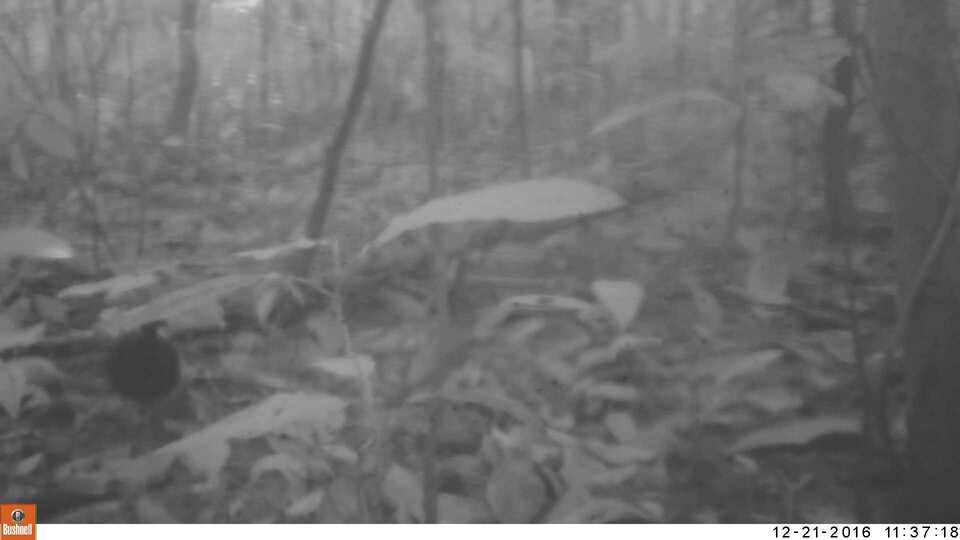

In [41]:
all_train_image_key = frame['s3_key']
all_train_image_key

image = get_image_from_s3(bucket_name, all_train_image_key[0])
image2 = get_image_from_s3(bucket_name, all_train_image_key[1])
image

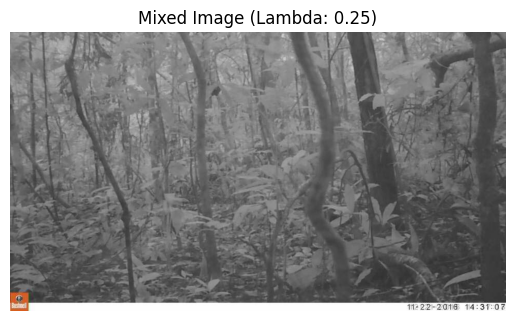

In [53]:
img1 = np.array(image)
img2 = np.array(image2)

# Ensure images are of type float for precise mixing
img1 = img1.astype(np.float32)
img2 = img2.astype(np.float32)

lambda_val = np.random.beta(0.4, 0.4)

mixed_image_np = (lambda_val * img1) + ((1 - lambda_val) * img2)

# Ensure the final array is clipped to valid pixel values (0-255) and cast back to uint8
mixed_image_np = np.clip(mixed_image_np, 0, 255).astype(np.uint8)

plt.imshow(mixed_image_np)
plt.axis('off') # Optional: hides axes and ticks for a cleaner look
plt.title(f"Mixed Image (Lambda: {lambda_val:.2f})")
plt.show()

In [10]:
for index, row in frame.iterrows():
    image_path = row["s3_key"]
    print(image_path)

data/train_features/ZJ000000.jpg
data/train_features/ZJ000001.jpg
data/train_features/ZJ000002.jpg
data/train_features/ZJ000003.jpg
data/train_features/ZJ000004.jpg
data/train_features/ZJ000005.jpg
data/train_features/ZJ000006.jpg
data/train_features/ZJ000007.jpg
data/train_features/ZJ000008.jpg
data/train_features/ZJ000009.jpg


In [11]:

def to_hwc3(img: np.ndarray) -> np.ndarray:
    if img.ndim == 2:  # (H, W) -> (H, W, 3)
        return np.repeat(img[..., None], 3, axis=2)
    if img.ndim == 3:
        if img.shape[2] == 1:  # (H, W, 1) -> (H, W, 3)
            return np.repeat(img, 3, axis=2)
        if img.shape[2] >= 3:  # (H, W, 3) or (H, W, 4) -> keep first 3
            return img[..., :3]
    raise ValueError(f"Unexpected shape: {img.shape}")





In [12]:
try:
        labels_obj = s3.get_object(Bucket=bucket_name, Key="data/train_labels.csv")
        labels_df = pd.read_csv(labels_obj["Body"])
        labels_df["filename"] = labels_df["id"] + ".jpg"
        print(f"Labels loaded: {len(labels_df)} rows")
        

        # Merge with image data
        # train_df = train_df.merge(labels_df, on="filename", how="left")
    # print(f"Merged dataset: {len(train_df)} rows")
except Exception as e:
    print(f"Could not load labels: {e}")
    sys.exit(0)
    
labels_df

Labels loaded: 16488 rows


,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,filename
0,ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,ZJ000000.jpg
1,ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,ZJ000001.jpg
2,ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,ZJ000002.jpg
3,ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,ZJ000003.jpg
4,ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ZJ000004.jpg
...,...,...,...,...,...,...,...,...,...,...
16483,ZJ016483,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ZJ016483.jpg
16484,ZJ016484,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ZJ016484.jpg
16485,ZJ016485,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,ZJ016485.jpg
16486,ZJ016486,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,ZJ016486.jpg


In [13]:
image = test_images[0]
im = get_image_from_s3(bucket_name, image)


In [14]:
im.mode

'RGB'

In [15]:
im = im.convert("RGB")

In [16]:
bands = im.getbands()
bands

('R', 'G', 'B')

In [17]:
train_folder = "data/train_features"
test_folder = "data/test_features"
train_features_csv = "data/train_features.csv"
test_features_csv = "data/test_features.csv"
train_labels_csv = "data/train_labels.csv"

In [18]:
train_cvs = s3.get_object(Bucket=bucket_name, Key=train_features_csv)
train_cvs = train_cvs["Body"].read()
csv_buffer = BytesIO(train_cvs)
df = pd.read_csv(csv_buffer)
df

# dataframe = pd.read_csv(train_cvs["Body"].read())


,id,filepath,site
0,ZJ000000,train_features/ZJ000000.jpg,S0120
1,ZJ000001,train_features/ZJ000001.jpg,S0069
2,ZJ000002,train_features/ZJ000002.jpg,S0009
3,ZJ000003,train_features/ZJ000003.jpg,S0008
4,ZJ000004,train_features/ZJ000004.jpg,S0036
...,...,...,...
16483,ZJ016483,train_features/ZJ016483.jpg,S0093
16484,ZJ016484,train_features/ZJ016484.jpg,S0043
16485,ZJ016485,train_features/ZJ016485.jpg,S0089
16486,ZJ016486,train_features/ZJ016486.jpg,S0095


In [19]:
test_cvs = s3.get_object(Bucket=bucket_name, Key=test_features_csv)
test_cvs = test_cvs["Body"].read()
csv_buffer = BytesIO(test_cvs)
df = pd.read_csv(csv_buffer)
df


,id,filepath,site
0,ZJ016488,test_features/ZJ016488.jpg,S0082
1,ZJ016489,test_features/ZJ016489.jpg,S0040
2,ZJ016490,test_features/ZJ016490.jpg,S0040
3,ZJ016491,test_features/ZJ016491.jpg,S0041
4,ZJ016492,test_features/ZJ016492.jpg,S0040
...,...,...,...
4459,ZJ020947,test_features/ZJ020947.jpg,S0086
4460,ZJ020948,test_features/ZJ020948.jpg,S0152
4461,ZJ020949,test_features/ZJ020949.jpg,S0162
4462,ZJ020950,test_features/ZJ020950.jpg,S0055


In [20]:
labels_csv = s3.get_object(Bucket=bucket_name, Key=train_labels_csv)
labels_csv = labels_csv["Body"].read()
csv_buffer = BytesIO(labels_csv)
df = pd.read_csv(csv_buffer)
df


,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
16483,ZJ016483,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
16484,ZJ016484,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16485,ZJ016485,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16486,ZJ016486,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:

processed_folder = "processed/train_features/"
numpy_data = []

for row in df.itertuples(index=False):
    print(row.id)
    path = os.path.join(processed_folder, row.id + ".jpg")
    
    print(path)
    image = s3.get_object(Bucket=bucket_name, Key=path)
    image = image["Body"].read()
    image = Image.open(BytesIO(image))
    numpy_data.append(np.array(image))

    
    
    break
print(numpy_data)
    
    


ZJ000000
processed/train_features/ZJ000000.jpg
[array([[[139, 139, 139],
        [139, 139, 139],
        [139, 139, 139],
        ...,
        [107, 107, 107],
        [107, 107, 107],
        [107, 107, 107]],

       [[140, 140, 140],
        [139, 139, 139],
        [139, 139, 139],
        ...,
        [108, 108, 108],
        [108, 108, 108],
        [109, 109, 109]],

       [[140, 140, 140],
        [140, 140, 140],
        [140, 140, 140],
        ...,
        [109, 109, 109],
        [110, 110, 110],
        [111, 111, 111]],

       ...,

       [[248, 150, 101],
        [215, 118,  67],
        [191,  94,  43],
        ...,
        [248, 248, 248],
        [255, 255, 255],
        [237, 237, 237]],

       [[253, 149,  96],
        [220, 116,  63],
        [197,  92,  35],
        ...,
        [252, 252, 252],
        [248, 248, 248],
        [252, 252, 252]],

       [[254, 149,  94],
        [221, 116,  59],
        [200,  91,  34],
        ...,
        [242, 242, 242],
 

In [22]:
numpy_data[0]

array([[[139, 139, 139],
        [139, 139, 139],
        [139, 139, 139],
        ...,
        [107, 107, 107],
        [107, 107, 107],
        [107, 107, 107]],

       [[140, 140, 140],
        [139, 139, 139],
        [139, 139, 139],
        ...,
        [108, 108, 108],
        [108, 108, 108],
        [109, 109, 109]],

       [[140, 140, 140],
        [140, 140, 140],
        [140, 140, 140],
        ...,
        [109, 109, 109],
        [110, 110, 110],
        [111, 111, 111]],

       ...,

       [[248, 150, 101],
        [215, 118,  67],
        [191,  94,  43],
        ...,
        [248, 248, 248],
        [255, 255, 255],
        [237, 237, 237]],

       [[253, 149,  96],
        [220, 116,  63],
        [197,  92,  35],
        ...,
        [252, 252, 252],
        [248, 248, 248],
        [252, 252, 252]],

       [[254, 149,  94],
        [221, 116,  59],
        [200,  91,  34],
        ...,
        [242, 242, 242],
        [242, 242, 242],
        [255, 255, 255]]

In [23]:

def folder_exists_and_not_empty(bucket:str, path:str) -> bool:
    '''
    Folder should exists. 
    Folder should not be empty.
    '''
    s3 = boto3.client('s3')
    if not path.endswith('/'):
        path = path+'/' 
    resp = s3.list_objects(Bucket=bucket, Prefix=path, Delimiter='/',MaxKeys=1)
    return 'Contents' in resp



print(folder_exists_and_not_empty(bucket_name, train_folder))
print(folder_exists_and_not_empty(bucket_name, test_folder))

train_exists = folder_exists_and_not_empty(bucket_name, train_folder)
test_exists = folder_exists_and_not_empty(bucket_name, test_folder)




True
True


In [ ]:
sizes = []

def get_image_size(image_key: str) -> tuple[int, int]:
    
    image_key = os.path.join(train_folder, image_key)
    image_obj = s3.get_object(
        Bucket=bucket_name, Key = image_key
    )
    image_data = image_obj["Body"].read()
    image = Image.open(BytesIO(image_data))
    return image.size

for i in train_images:
    sizes.append(get_image_size(i))
    
def get_image_keys_with_paginator(bucket, prefix):
    """Get all image keys using boto3 paginator"""
    image_keys = []
    
    # Create paginator
    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=bucket, Prefix=prefix)
    
    # Iterate through all pages
    for page in pages:
        for obj in page.get('Contents', []):
            key = obj['Key']
            if key.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                image_keys.append(key)
    
    return image_keys
    


# for i in train_images:
#     sizes.append(get_image_size(i))
    


test_cvs = s3.get_object(Bucket=bucket_name, Key=test_features_csv)
test_cvs = test_cvs["Body"].read()
csv_buffer = BytesIO(test_cvs)
test_dataframe = pd.read_csv(csv_buffer)
print(test_dataframe.head())
path = list(test_dataframe['filepath'])
for i in path:
    sizes.append(get_image_size(i))
    


         id                    filepath   site
0  ZJ016488  test_features/ZJ016488.jpg  S0082
1  ZJ016489  test_features/ZJ016489.jpg  S0040
2  ZJ016490  test_features/ZJ016490.jpg  S0040
3  ZJ016491  test_features/ZJ016491.jpg  S0041
4  ZJ016492  test_features/ZJ016492.jpg  S0040


In [35]:
for index, id in test_dataframe.iterrows():
    # print(id)
    print(id)
    print(id['filepath'])
    # print(index)
    # print(test_dataframe.iloc[index])
    break


id                            ZJ016488
filepath    test_features/ZJ016488.jpg
site                             S0082
Name: 0, dtype: object
test_features/ZJ016488.jpg


In [37]:
class TestDataset(Dataset):
    def __init__(self, dataframe, transform=None, base_dir=""):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.base_dir = base_dir

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        rel_path = row["filepath"]  # e.g. "test_features/abc.jpg"
        image_path = os.path.join(self.base_dir, rel_path)

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, row

In [39]:

val_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_dataset = TestDataset(test_dataframe, transform=val_transform, base_dir=test_base)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:10                                                                                   │
│                                                                                                  │
│    7 │   ]                                                                                       │
│    8 )                                                                                           │
│    9                                                                                             │
│ ❱ 10 test_dataset = TestDataset(test_dataframe, transform=val_transform, base_dir=test_base)     │
│   11                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'test_base' is not defined

In [40]:
labels_csv = s3.get_object(Bucket=bucket_name, Key=train_labels_csv)
labels_csv = labels_csv["Body"].read()
csv_buffer = BytesIO(labels_csv)
df = pd.read_csv(csv_buffer)
df


,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
16483,ZJ016483,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
16484,ZJ016484,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16485,ZJ016485,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16486,ZJ016486,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
